## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/MyDrive/wav.zip

In [4]:
!mkdir models
!mkdir models/saved_models
!mkdir models/training_results

In [5]:
import pandas as pd
import json
import math, random
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import random_split, Subset
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim
import torchaudio
from torchaudio import transforms


## AudioUtil

In [ ]:
class AudioUtil():
  
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file, normalize=True)
    return (sig, sr)

  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      
      return aud

    if (new_channel == 1):
      resig = sig[:1, :]
    else:
      resig = torch.cat([sig, sig])

    return ((resig, sr))
  
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      return aud

    num_channels = sig.shape[0]
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))


  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=2048, hop_len=None):
    sig,sr = aud
    top_db = 80

    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)


  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

  @staticmethod
  def plot_spec(sig):
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(sig[0].numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title("Spectrogram [0]")
    plt.ylabel("Frequency")
    plt.xlabel("Time")
    plt.colorbar(label="dB")

    plt.subplot(1, 2, 2)
    plt.imshow(sig[1].numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title("Spectrogram [1]")
    plt.ylabel("Frequency")
    plt.xlabel("Time")
    plt.colorbar(label="dB")

    plt.show()

## Dataset

In [21]:
class InstrumentsDS(Dataset):

    MAX_NUM_SAMPLES = 4395
    METADATA_CSV = "gdrive/MyDrive/metadata.csv"

    def __init__(self, data_dir, num_samples_per_class, type_of_output):
        super(InstrumentsDS).__init__()
        self.data_dir = data_dir
        self.csv = pd.read_csv(InstrumentsDS.METADATA_CSV)
        self.type_of_output = type_of_output

        # if None we use the whole dataset
        if num_samples_per_class is None:
            self.mapping = self.csv
        else :
            if num_samples_per_class <= InstrumentsDS.MIN_NUM_SAMPLES:
                self.mapping = self.csv.groupby('classID').sample(num_samples_per_class, random_state=12)
            else:
                raise Exception(f"num_samples_per_class must be inferior to {InstrumentsDS.MIN_NUM_SAMPLES} or None")

    def __len__(self):
        return self.mapping.shape[0]

    def __getitem__(self, idx):
        if self.data_dir == "spec":
            tensor_file = f"{self.mapping.iloc[idx, 0][0:-4]}.pt"
            class_id = self.mapping.iloc[idx, 1]
            class_id = int(class_id)

            tensor = torch.load(tensor_file)

            if self.type_of_output == "lstm":
              return tensor[0], class_id

            else :
              return tensor, class_id

        else:
            audio_file = f"{self.data_dir}/{self.mapping.iloc[idx, 0]}"
            class_id = self.mapping.iloc[idx, 1]
            class_id = int(class_id)
            aud = AudioUtil.open(audio_file)

            sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
            aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

            return aug_sgram, class_id

## Dataset visualization

    class  count
0   cello   9140
1  guitar   5299
2   piano   7175
3  violin   4395
26009


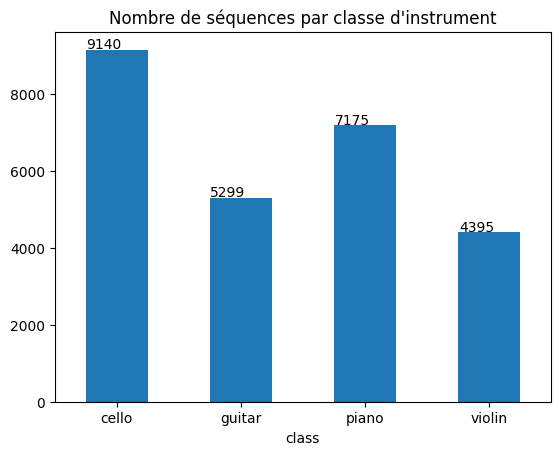

   index  repartition
0      0     0.351417
1      1     0.203737
2      2     0.275866
3      3     0.168980


In [23]:
dataset_csv = pd.read_csv("gdrive/MyDrive/metadata.csv")
df = dataset_csv.groupby('class').size().reset_index(name='count')
total = df.sum(axis=0).iloc[1]

print(df)
print(total)

ax = df.plot.bar(x='class', y='count', rot=0, legend=False)

plt.title('Nombre de séquences par classe d\'instrument')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Show the plot
plt.show()

df_rep = df['count'].apply(lambda x: x / total).reset_index(name='repartition')
print(df_rep)

<ipython-input-15-ec851113f5d4>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(tensor_file)


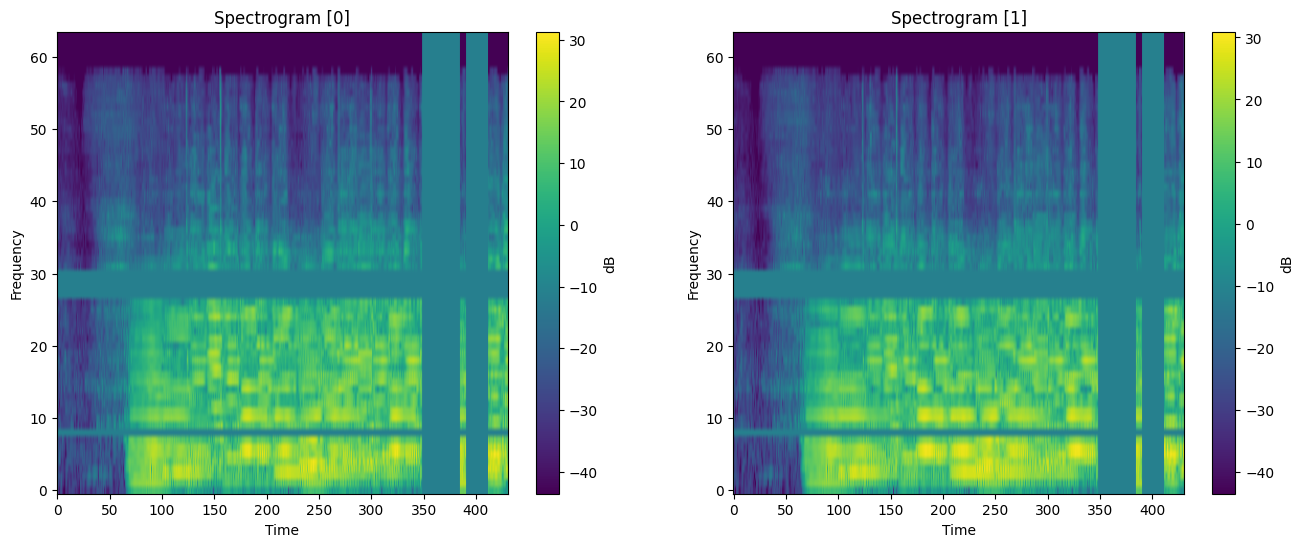

In [19]:
ds = InstrumentsDS('spec', None, "CNN")
item = ds[0]
AudioUtil.plot_spec(item[0])

## CNN Classifier

In [ ]:
class CNN_Classifier(nn.Module):

    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers.extend([self.conv1, self.relu1, self.pool1])

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers.extend([self.conv2, self.relu2, self.pool2])

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers.extend([self.conv3, self.relu3, self.pool3])

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers.extend([self.conv4, self.relu4])

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=4)

        self.conv = nn.Sequential(*conv_layers)


    def forward(self, x):

        x = self.conv(x)

        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        x = self.lin(x)
        return x

model = CNN_Classifier()
print(model)

## LSTM Classifier

In [ ]:
class LSTM_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTM_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 431
hidden_dim = 862
output_dim = 4
num_layers = 2
dropout = 0.5

model = LSTM_Classifier(input_dim, hidden_dim, output_dim, num_layers, dropout)
print(model)

## bi-LSTM Classifier

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return output


vocab_size = 10000
embedding_dim = 128
hidden_dim = 64
output_dim = 4
n_layers = 2
bidirectional = True
dropout = 0.5

model = BiLSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BiLSTMClassifier(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## TrainingUtil

In [61]:
class Training:

    LOSS_WEIGHTS = torch.tensor(df_rep['repartition'].to_list(), dtype=torch.float32)

    def validation_loop(model, val_dl, device, criterion):
        model.eval()
        correct = 0
        total_pred = 0
        loss = 0

        with torch.no_grad():
            for data in val_dl:
                inputs, labels = data[0].to(device), data[1].to(device)

                 # Normalize the inputs
                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs = (inputs - inputs_m) / inputs_s

                outputs = model(inputs)
                _, pred = torch.max(outputs, 1)

                loss += criterion(outputs, labels).item()
                correct += (pred == labels).sum().item()
                total_pred += pred.shape[0]

        return loss / len(val_dl), correct / total_pred

    def training_loop(model, train_dl, val_dl, num_epochs, device, lr, criterion):
        # Loss Function, Optimizer and Scheduler
        optimizer = torch.optim.Adam(model.parameters(),lr=lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
        loss_over_epochs = []
        acc_over_epochs = []
        eval_loss_over_epochs = []
        eval_acc_over_epochs = []

        # Repeat for each epoch
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_prediction = 0
            total_prediction = 0

            # Repeat for each batch in the training set
            for i, data in tqdm(enumerate(train_dl)):

                inputs, labels = data[0].to(device), data[1].to(device)

                # Normalize the inputs
                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs = (inputs - inputs_m) / inputs_s

                # Zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()

                # Keep stats for Loss and Accuracy
                running_loss += loss.item()

                # Get the predicted class with the highest score
                _, prediction = torch.max(outputs,1)
                # Count of predictions that matched the target label
                correct_prediction += (prediction == labels).sum().item()
                total_prediction += prediction.shape[0]

            eval_loss, eval_acc = Training.validation_loop(model, val_dl, device, criterion)
            eval_loss_over_epochs.append(eval_loss)
            eval_acc_over_epochs.append(eval_acc)

            num_batches = len(train_dl)
            avg_loss = running_loss / num_batches
            acc = correct_prediction / total_prediction
            loss_over_epochs.append(avg_loss)
            acc_over_epochs.append(acc)

            print(f'Epoch: {epoch}\nLoss: {avg_loss}, Accuracy: {acc}\nValidation Loss: {eval_loss}, Validation Accuracy: {eval_acc}')

        print('Finished Training')
        return loss_over_epochs, acc_over_epochs, eval_loss_over_epochs, eval_acc_over_epochs

## Training CNN


In [ ]:
NUM_EPOCH = 25
DATASET_SIZE = None
DATASET_HZ = "spec"
MODEL_TYPE = "CNN"
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training running on {device}")

model = CNN_Classifier().to(device)
ds = InstrumentsDS('spec', DATASET_SIZE, MODEL_TYPE)

num_items = len(ds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(ds, [num_train, num_val])
print(num_items)

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)


if DATASET_SIZE != None :
  loss = torch.nn.CrossEntropyLoss()
  loss_over_epochs, acc_over_epochs, eval_loss_over_epochs, eval_acc_over_epochs = Training.training_loop(model,
                                                                                                          train_dl,
                                                                                                          val_dl,
                                                                                                          NUM_EPOCH,
                                                                                                          device,
                                                                                                          LR,
                                                                                                          loss)
else :
  Training.LOSS_WEIGHTS = Training.LOSS_WEIGHTS.to(device)
  loss = torch.nn.CrossEntropyLoss(weight=Training.LOSS_WEIGHTS)
  loss_over_epochs, acc_over_epochs, eval_loss_over_epochs, eval_acc_over_epochs = Training.training_loop(model,
                                                                                                          train_dl,
                                                                                                          val_dl,
                                                                                                          NUM_EPOCH,
                                                                                                          device,
                                                                                                          LR,
                                                                                                          loss)
to_json = {
    "loss": loss_over_epochs,
    "accuracy": acc_over_epochs,
    "eval_loss": eval_loss_over_epochs,
    "eval_accuracy": eval_acc_over_epochs
}

if DATASET_SIZE != None :

  torch.save(model.state_dict(), f'models/saved_models/{MODEL_TYPE}_{DATASET_SIZE}.pth')
  with open(f'models/training_results/training_results_{MODEL_TYPE}_{DATASET_SIZE}.json', 'w') as json_file:
      json.dump(to_json, json_file)

else :

  torch.save(model.state_dict(), f'models/saved_models/{MODEL_TYPE}_alldataset.pth')
  with open(f'models/training_results/training_results_{MODEL_TYPE}_alldataset.json', 'w') as json_file:
      json.dump(to_json, json_file)

print("Model saved")

## Training LSTM

In [ ]:
NUM_EPOCH = 25 # Training time 19mn
DATASET_SIZE = None
DATASET_HZ = "spec"
MODEL_TYPE = "lstm"
LR = 0.001

input_dim = 431
hidden_dim = 862
output_dim = 4
num_layers = 2
dropout = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training running on {device}")

model = LSTM_Classifier(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
ds = InstrumentsDS('spec', DATASET_SIZE, MODEL_TYPE)

num_items = len(ds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(ds, [num_train, num_val])
print(num_items)

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)


if DATASET_SIZE != None :
  loss = torch.nn.CrossEntropyLoss()
  loss_over_epochs, acc_over_epochs, eval_loss_over_epochs, eval_acc_over_epochs = Training.training_loop(model,
                                                                                                          train_dl,
                                                                                                          val_dl,
                                                                                                          NUM_EPOCH,
                                                                                                          device,
                                                                                                          LR,
                                                                                                          loss)
else :
  Training.LOSS_WEIGHTS = Training.LOSS_WEIGHTS.to(device)
  loss = torch.nn.CrossEntropyLoss(weight=Training.LOSS_WEIGHTS)
  loss_over_epochs, acc_over_epochs, eval_loss_over_epochs, eval_acc_over_epochs = Training.training_loop(model,
                                                                                                          train_dl,
                                                                                                          val_dl,
                                                                                                          NUM_EPOCH,
                                                                                                          device,
                                                                                                          LR,
                                                                                                          loss)

to_json = {
    "loss": loss_over_epochs,
    "accuracy": acc_over_epochs,
    "eval_loss": eval_loss_over_epochs,
    "eval_accuracy": eval_acc_over_epochs
}

if DATASET_SIZE != None :

  torch.save(model.state_dict(), f'models/saved_models/{MODEL_TYPE}_{DATASET_SIZE}.pth')
  with open(f'models/training_results/training_results_{MODEL_TYPE}_{DATASET_SIZE}.json', 'w') as json_file:
      json.dump(to_json, json_file)

else :

  torch.save(model.state_dict(), f'models/saved_models/{MODEL_TYPE}_alldataset.pth')
  with open(f'models/training_results/training_results_{MODEL_TYPE}_alldataset.json', 'w') as json_file:
      json.dump(to_json, json_file)

print("Model saved")